### Load packages and read tables.

In [2]:
%run /Users/J.Kim54@lse.ac.uk/pubg_analysis

In [3]:
# In this section, we need records of cheaters between March 1 and March 31.
# However, I am using records between March 1 and March 15 due to the size limit.
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read a table that contains telemetry data.
td = spark.read.parquet("/tmp/td_day_7_4.parquet")
td.registerTempTable("td")

# Read a table that contains player data.
players = spark.sql("SELECT * FROM td_nodes")
players.registerTempTable("players")

# Get cheaters who were banned between March 1 and March 7.
cheaters = spark.sql("SELECT * FROM td_nodes WHERE ban_date <= '2019-03-07'")
cheaters.registerTempTable("cheaters")

### Calculate the average kill ratio for each cheater.

In [5]:
# Create a dataframe that stores kill records of cheaters.
c_kill_logs = spark.sql("SELECT mid, src, dst, time, m_date, ban_date FROM td t JOIN cheaters c ON t.src = c.id")
c_kill_logs.registerTempTable("c_kill_logs")

# Calculate the number of kills of each cheater by date.
c_kills_by_date = spark.sql("SELECT src AS id, m_date, COUNT(*) AS kills FROM c_kill_logs GROUP BY src, m_date")
c_kills_by_date_df = c_kills_by_date.toPandas()

# Create a dataframe that stores death records of cheaters.
c_death_logs = spark.sql("SELECT mid, src, dst, time, m_date, ban_date FROM td t JOIN cheaters c ON t.dst = c.id")
c_death_logs.registerTempTable("c_death_logs")

# Calculate the number of deaths of each cheater by date.
c_deaths_by_date = spark.sql("SELECT dst AS id, m_date, COUNT(*) AS deaths FROM c_death_logs GROUP BY dst, m_date")
c_deaths_by_date_df = c_deaths_by_date.toPandas()

# Create a dataframe that contains both kills and deaths of each cheater by date.
dates_from_kills = c_kills_by_date_df[['id', 'm_date']]
dates_from_deaths = c_deaths_by_date_df[['id', 'm_date']]
temp = pd.concat([dates_from_kills, dates_from_deaths])
temp = temp.drop_duplicates(subset=['id', 'm_date'])
# print(temp)

# Merge the two dataframes into one.
kill_info = pd.merge(temp, c_kills_by_date_df, how='outer', on=['id', 'm_date'])
kill_info = kill_info.fillna(0)
merged_df = pd.merge(kill_info, c_deaths_by_date_df, how='outer', on=['id', 'm_date'])
merged_df = merged_df.fillna(0)
# print(merged_df)

# Calculate the kill ratio of each cheater by date.
merged_df['kill_ratio'] = merged_df['kills']/(merged_df['kills']+merged_df['deaths'])
kill_ratio_tab = merged_df[['id', 'm_date', 'kill_ratio']].sort_values(by=['id', 'm_date'])
# print(kill_ratio_tab)

### Calculate the average time difference between consecutive kills for each cheater.

In [7]:
# Get a dataframe that stores kill records of cheaters.
c_kill_logs = spark.sql("SELECT mid, src, dst, time, m_date, ban_date FROM td t JOIN cheaters c ON t.src = c.id")
kill_logs = c_kill_logs.toPandas()

# Calculate the time difference between kills for each match
kill_logs = kill_logs.sort_values(['src', 'mid', 'time'])
kill_logs['time'] = pd.to_datetime(kill_logs['time'])
kill_logs['delta'] = kill_logs.groupby(['mid', 'src'])['time'].diff()
kill_logs['delta'] = kill_logs['delta'] / np.timedelta64(1, 's')

# Calculate the average time difference between kills of cheaters by date.
time_diff_df = kill_logs[['src', 'm_date', 'delta']]
avg_kill_interval_by_date = time_diff_df.groupby(['src', 'm_date'], as_index=False).mean()
# print(avg_kill_interval_by_date)

### Estimate the start date of cheating for each cheater by using the information above.

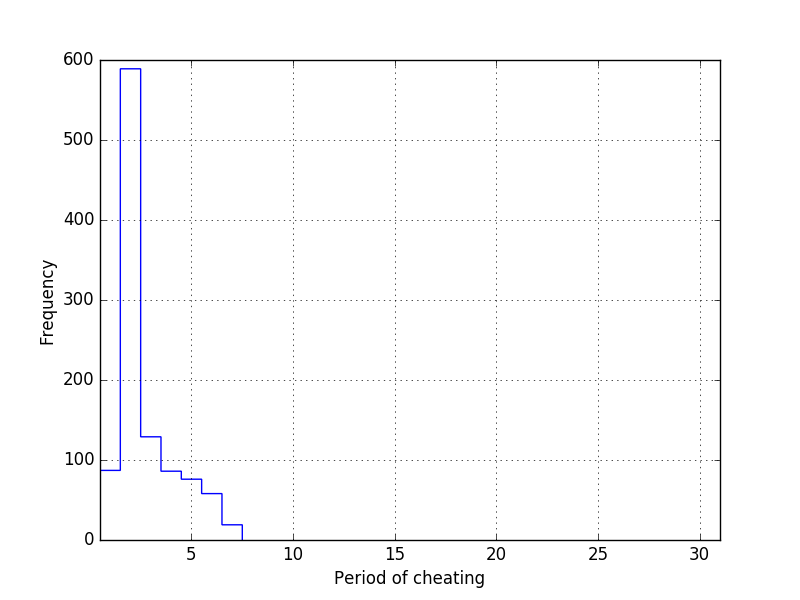

In [9]:
# First, estimate the start date of cheating for cheaters who have full performance information.
estim_result = estimate_start_date_of_cheating(kill_ratio_tab, avg_kill_interval_by_date)
# print(estim_result)
cheaters_with_full_info = get_cheaters_with_full_info(estim_result)

# Count the number of cheaters who did cheat for two days.
# print(len(cheaters_with_full_info[cheaters_with_full_info['period']==2]))

# Plot the distribution of the period of cheating.
# The plot contains cheaters who have full performance information.
bins = np.arange(0, cheaters_with_full_info['period'].max() + 1.5) - 0.5
fig = cheaters_with_full_info.hist(bins = bins, histtype='step')
plt.title('')
plt.xlim(xmin = 0.5)
plt.xlim(xmax = 31)
plt.xlabel('Period of cheating')
plt.ylabel('Frequency')
image = plt.show() 
display(image)

# Calculate the mean and median of period of cheating.
print(cheaters_with_full_info['period'].mean())
print(cheaters_with_full_info['period'].median())

In [10]:
# Apply the modal value for cheaters with at least one missing information.
estim_all_cheaters = fill_missing_values(estim_result)
# print(estim_all_cheaters)

# Plot the distribution of the period of cheating.
# The plot contains all cheaters.
'''estim_all_cheaters['period'] = estim_all_cheaters['period'].astype('int')
bins = np.arange(0, estim_all_cheaters['period'].max() + 1.5) - 0.5
fig = estim_all_cheaters['period'].hist(bins=bins, histtype='step')
plt.title('')
plt.xlim(xmin = 0.5)
plt.xlabel('Period of cheating')
plt.ylabel('Frequency')
image = plt.show() 
display(image)'''

In [11]:
# Store the estimated start dates as a parquet file.
# cheater_info = spark.createDataFrame(estim_all_cheaters)
# cheater_info.write.parquet("/tmp/cheater_info.parquet")